##Setup and Install Dependencies

In [1]:
# Import libraries
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import seaborn as sns
import numpy as np
import os
import zipfile
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Setup

In [3]:
!curl -L -o master.zip https://www.kaggle.com/api/v1/datasets/download/ankurpaul52/balanced-multi-crop-plant-disease-dataset
!unzip -q  master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1111M  100 1111M    0     0  20.7M      0  0:00:53  0:00:53 --:--:-- 22.5M


## Data Preparation and Exploration
 Split dataset into train/val/test folders

In [4]:
import shutil
import random
from pathlib import Path

def split_dataset(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    # Ensure ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.01, "Ratios must sum to 1"

    # Create destination directories
    train_dir = os.path.join(dest_dir, 'train')
    val_dir = os.path.join(dest_dir, 'val')
    test_dir = os.path.join(dest_dir, 'test')

    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get all class folders (disease types)
    class_folders = [f for f in os.listdir(source_dir)
                    if os.path.isdir(os.path.join(source_dir, f))]

    print(f"Found {len(class_folders)} classes: {class_folders}")

    # Process each class separately
    for class_name in class_folders:
        class_path = os.path.join(source_dir, class_name)

        # Create class folders in train/val/test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Get all image files for this class
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        # Shuffle the files
        random.shuffle(image_files)

        # Calculate split pointsr
        n_total = len(image_files)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        n_test = n_total - n_train - n_val  # Remainder goes to test

        print(f"\nClass '{class_name}': {n_total} images")
        print(f"  Train: {n_train}, Val: {n_val}, Test: {n_test}")

        # Split the files
        train_files = image_files[:n_train]
        val_files = image_files[n_train:n_train + n_val]
        test_files = image_files[n_train + n_val:]

        # Copy files to respective folders
        for file_name in train_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(train_dir, class_name, file_name)
            shutil.copy2(src, dst)

        for file_name in val_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(val_dir, class_name, file_name)
            shutil.copy2(src, dst)

        for file_name in test_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(test_dir, class_name, file_name)
            shutil.copy2(src, dst)

    print(f"\nDataset split completed!")
    print(f"Organized data saved to: {dest_dir}")




In [5]:
# Define dataset paths - adjust these based on your dataset structure
BASE_DIR = '/content/datasets/mango'
CORN_DIR = os.path.join('data')
split_dataset(BASE_DIR, CORN_DIR, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

Found 4 classes: ['Mango__Gall_Midge', 'Mango__Healthy', 'Mango__Powdery_Mildew', 'Mango__Sooty_Mould']

Class 'Mango__Gall_Midge': 1200 images
  Train: 960, Val: 120, Test: 120

Class 'Mango__Healthy': 1200 images
  Train: 960, Val: 120, Test: 120

Class 'Mango__Powdery_Mildew': 1199 images
  Train: 959, Val: 119, Test: 121

Class 'Mango__Sooty_Mould': 1200 images
  Train: 960, Val: 120, Test: 120

Dataset split completed!
Organized data saved to: data


## Data Preprocessing and Augmentation

Augmentation should be handled based on the availability of data. If you have limited data (say a few hundred images) then aggressive augmentation can result in inefficient training. Because in that case the the images will become too different for model to learn patterns. In such a case go with low augmentation.
This method does not increase the number of images.

In [6]:
# Configuration
PLANT_NAME = 'Mango'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42

# Set random seeds
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

BASE_DIR = '/content/data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    zoom_range=0.3,
    channel_shift_range=0.2,
    fill_mode='reflect',
    horizontal_flip=True,

)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED
)


Found 3839 images belonging to 4 classes.
Found 479 images belonging to 4 classes.
Found 481 images belonging to 4 classes.


In [7]:
# Get class information
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 4
Class names: ['Mango__Gall_Midge', 'Mango__Healthy', 'Mango__Powdery_Mildew', 'Mango__Sooty_Mould']


## Visualize Sample Images

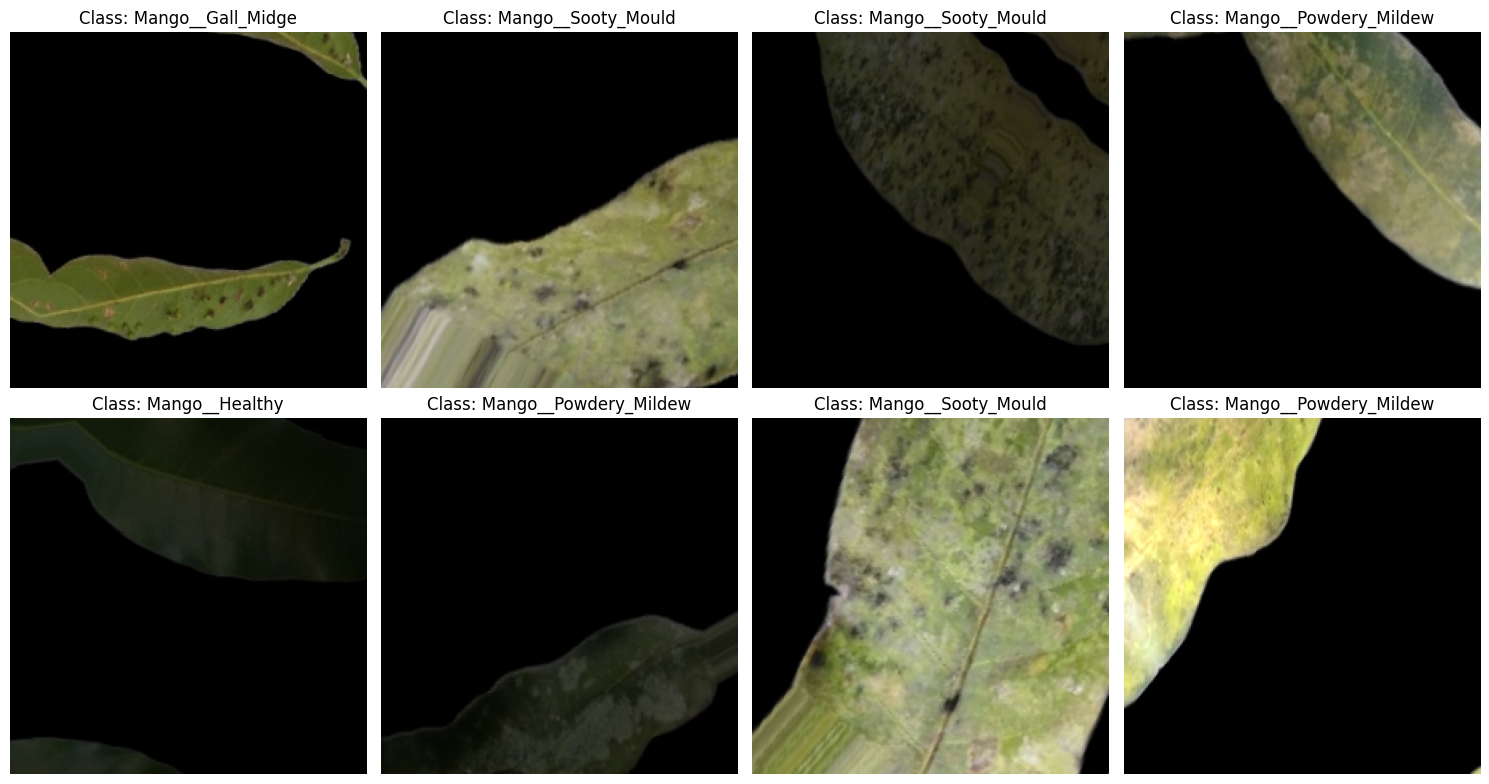

In [8]:
def plot_sample_images(generator, class_names, num_images=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    # Get a batch of images
    images, labels = next(generator)

    for i in range(min(num_images, len(images))):
        img = images[i]
        label_idx = np.argmax(labels[i])
        class_name = class_names[label_idx]

        axes[i].imshow(img)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
plot_sample_images(train_generator, class_names)

##  Build MobileNetV2 Model

1. **Feature extractor (MobileNetV2)** - recognizes patterns
2. **Classifier head** - makes final disease prediction

This version keeps the base model in inference mode during fine-tuning, similar to the Keras [Xception example](https://keras.io/guides/transfer_learning/). This is an easy pitfall which can often go unnoticed. The BatchNormalization layers should be kept frozen (Non trainable) even if the base model (In this case MobileNetV2) is being fine tuned otherwise the accuracy can drop drastically in the first epoch of fine tune.

In [9]:
def create_mobilenet_model(num_classes, img_size=(224, 224, 3)):

    # Load pre-trained MobileNetV2 (without top layer)
    base_model = MobileNetV2(
        input_shape=img_size,
        include_top=False,
        weights='imagenet',
        alpha=1.0  # Width multiplier
    )

    # Freeze base model initially
    base_model.trainable = False

    # Create model using Functional API to control training mode
    from tensorflow.keras import Input, Model
    inputs = Input(shape=img_size)

    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model, base_model

In [10]:
# Create the model
model, base_model = create_mobilenet_model(num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,236 (8.77 MB)

 Trainable params: 41,188 (160.89 KB)

 Non-trainable params: 2,258,048 (8.61 MB)

##  Model Compilation and Callbacks

In [11]:
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")

Trainable layers: 0


In [12]:
callbacks = [
    # Save best model based on validation accuracy
    ModelCheckpoint(
        f'/content/drive/MyDrive/models/{PLANT_NAME}_best_model_2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),

    # Stop training if no improvement
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True
    ),

    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Initial Training (Feature Extraction)

In [14]:
print("Stage 1: Training classifier head (base model frozen)")
print("="*50)

# Train only the classifier head first
EPOCHS_STAGE1 = 10

history_stage1 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE1,
    validation_data=validation_generator,
    callbacks=callbacks
)

Stage 1: Training classifier head (base model frozen)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 86s 620ms/step - accuracy: 0.7691 - loss: 0.6238 - val_accuracy: 0.9478 - val_loss: 0.1400 - learning_rate: 0.0010
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 62s 513ms/step - accuracy: 0.9159 - loss: 0.2407 - val_accuracy: 0.9770 - val_loss: 0.0794 - learning_rate: 0.0010
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 63s 526ms/step - accuracy: 0.9316 - loss: 0.1919 - val_accuracy: 0.9729 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 62s 521ms/step - accuracy: 0.9456 - loss: 0.1545 - val_accuracy: 0.9916 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 524ms/step - accuracy: 0.9535 - loss: 0.1395 - val_accuracy: 0.9812 - val_loss: 0.0560 - learning_rate: 0.0010
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 61s 510ms/step - accuracy: 0.9603 - loss: 0.1292 - val_accuracy: 0.9833 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 63s 523ms/step - accuracy: 0.9

## Fine-tuning (Unfreeze Base Model)

In [15]:
print(len(base_model.layers))

154


In [16]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = -20

# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Keep all BatchNormalization layers frozen
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,236 (8.77 MB)

 Trainable params: 1,236,068 (4.72 MB)

 Non-trainable params: 1,063,168 (4.06 MB)

In [17]:
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")

Trainable layers: 13


In [18]:
print("\nStage 2: Fine-tuning model")
print("="*50)

# Continue training
EPOCHS_STAGE2 = 12

history_stage2 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE2,
    validation_data=validation_generator,
    callbacks=callbacks
)


Stage 2: Fine-tuning model
Epoch 1/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 585ms/step - accuracy: 0.9627 - loss: 0.1112 - val_accuracy: 0.9979 - val_loss: 0.0245 - learning_rate: 1.0000e-05
Epoch 2/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 62s 518ms/step - accuracy: 0.9663 - loss: 0.1062 - val_accuracy: 0.9979 - val_loss: 0.0171 - learning_rate: 1.0000e-05
Epoch 3/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 522ms/step - accuracy: 0.9713 - loss: 0.0940 - val_accuracy: 0.9979 - val_loss: 0.0181 - learning_rate: 1.0000e-05
Epoch 4/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 61s 510ms/step - accuracy: 0.9718 - loss: 0.0904 - val_accuracy: 0.9937 - val_loss: 0.0290 - learning_rate: 1.0000e-05
Epoch 5/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 62s 516ms/step - accuracy: 0.9738 - loss: 0.0852 - val_accuracy: 0.9979 - val_loss: 0.0171 - learning_rate: 5.0000e-06
Epoch 6/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 62s 519ms/step - accuracy: 0.9740 - loss: 0.0773 - val_accuracy: 0.9979 - val_loss: 0.0166 - learning_rate: 5.0000e-06
Epoch 7/12
120/120

## Training Visualization

In [19]:
def plot_training_history(history1, history2=None):

    # Combine histories
    if history2:
        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
        epochs_range = range(len(acc))
        stage1_epochs = len(history1.history['accuracy'])
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']
        epochs_range = range(len(acc))
        stage1_epochs = 0

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    if stage1_epochs > 0:
        plt.axvline(x=stage1_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning starts')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    if stage1_epochs > 0:
        plt.axvline(x=stage1_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning starts')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

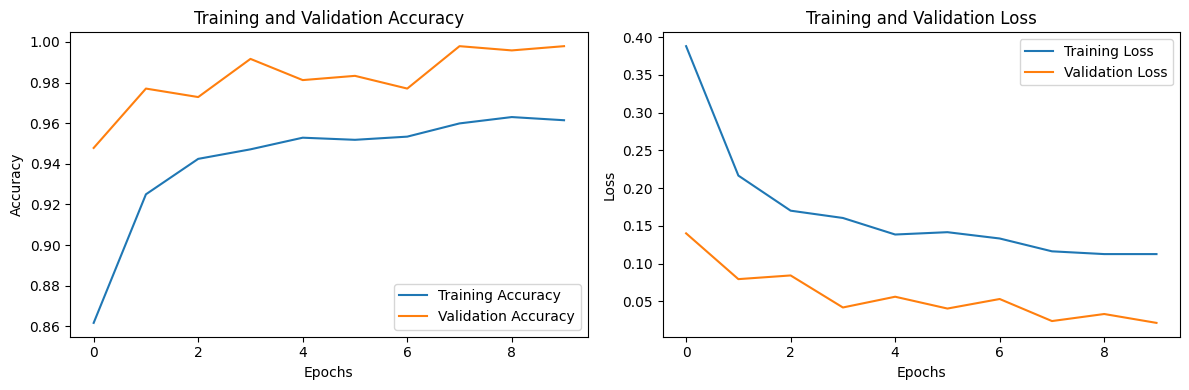

In [20]:
# Plot training history
plot_training_history(history_stage1) # history_stage2

## Model Evaluation

In [21]:
# # Load the best model
# model = tf.keras.models.load_model('/content/drive/MyDrive/models/best_model.keras')

In [22]:
# Evaluate on test set
print("Final Model Evaluation:")
print("="*30)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Validation Loss: {test_loss:.4f}")
print(f"Validation Accuracy: {test_accuracy:.4f}")
# print(f"Validation Top-3 Accuracy: {test_top3_accuracy:.4f}")

Final Model Evaluation:
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.9830 - loss: 0.0461
Validation Loss: 0.0431
Validation Accuracy: 0.9854


In [23]:
# Generate predictions for detailed analysis
test_generator.reset()  # Reset generator
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step


In [24]:
# Classification report
print("\nClassification Report:")
print("="*50)

# Get the actual class labels from the test generator
actual_class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=actual_class_labels))


Classification Report:
                       precision    recall  f1-score   support

    Mango__Gall_Midge       0.98      0.97      0.98       120
       Mango__Healthy       1.00      1.00      1.00       120
Mango__Powdery_Mildew       1.00      0.97      0.98       121
   Mango__Sooty_Mould       0.96      1.00      0.98       120

             accuracy                           0.99       481
            macro avg       0.99      0.99      0.99       481
         weighted avg       0.99      0.99      0.99       481



## Confusion Matrix

Label Legend:
GM: Mango__Gall_Midge
HLT: Mango__Healthy
PM: Mango__Powdery_Mildew
SM: Mango__Sooty_Mould


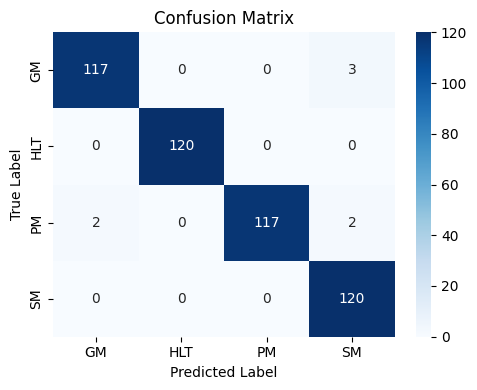

In [25]:
# Create ultra-short labels
label_mapping = {
    'Mango__Gall_Midge': 'GM',
    'Mango__Healthy': 'HLT',
    'Mango__Powdery_Mildew': 'PM',
    'Mango__Sooty_Mould': 'SM'
}

# Convert your class labels to short forms
short_labels = [label_mapping.get(label, label[:3]) for label in class_labels]

# Plot confusion matrix with short labels
plt.figure(figsize=(5, 4))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=short_labels, yticklabels=short_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Optional: Print legend for reference
print("Label Legend:")
for full, short in label_mapping.items():
    print(f"{short}: {full.replace(f'{PLANT_NAME}___', '')}")

plt.show()

## Visualize Result
Creates a visual test board displaying model predictions vs actual labels

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image

def create_test_board(model, test_generator, class_names,
                     grid_size=(5, 5), figsize=(20, 20),
                     title=f"{PLANT_NAME} Leaf Disease Detection Results\n"):
    """
    Creates a visual test board displaying model predictions vs actual labels

    Parameters:
    - model: trained model
    - test_generator: ImageDataGenerator for test data
    - class_names: List of disease class names
    - grid_size: Tuple (rows, cols) for the grid layout
    - figsize: Figure size for the display
    - title: Main title for the board
    """

    rows, cols = grid_size
    total_images = rows * cols

    # Create the figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title, fontsize=24, fontweight='bold', y=0.98)

    # Flatten axes for easier indexing
    if rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    # Get a batch of test images and their true labels
    test_batch, true_labels = next(test_generator)

    # Ensure we don't exceed available images
    num_images = min(total_images, len(test_batch))

    # Make predictions
    predictions = model.predict(test_batch[:num_images])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels[:num_images], axis=1)

    for i in range(num_images):
        # Display the image
        img = test_batch[i]
        if img.shape[-1] == 1:  # Grayscale
            axes[i].imshow(img.squeeze(), cmap='gray')
        else:  # RGB
            # Normalize image if needed
            if img.max() <= 1.0:
                img_display = img
            else:
                img_display = img / 255.0
            axes[i].imshow(img_display)

        # Get class names
        true_class = class_names[true_classes[i]]
        pred_class = class_names[predicted_classes[i]]
        confidence = np.max(predictions[i]) * 100

        # Create title with actual vs predicted
        is_correct = true_classes[i] == predicted_classes[i]
        color = 'green' if is_correct else 'red'

        title_text = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%"

        axes[i].set_title(title_text, fontsize=10, color=color,
                         fontweight='bold' if not is_correct else 'normal')
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    return fig

def create_detailed_test_board(model, test_generator, class_names,
                              samples_per_class=3, figsize=(20, 15)):
    """
    Creates a more detailed test board organized by disease classes
    """

    num_classes = len(class_names)

    # Create figure with subplots arranged by class
    fig, axes = plt.subplots(num_classes, samples_per_class,
                            figsize=figsize)
    fig.suptitle(f"{PLANT_NAME} Disease Detection - Organized by Class",
                fontsize=20, fontweight='bold')

    if num_classes == 1:
        axes = axes.reshape(1, -1)

    # Collect samples for each class
    class_samples = {i: [] for i in range(num_classes)}

    # Iterate through test data to collect samples
    for batch_imgs, batch_labels in test_generator:
        batch_true_classes = np.argmax(batch_labels, axis=1)

        for img, true_class in zip(batch_imgs, batch_true_classes):
            if len(class_samples[true_class]) < samples_per_class:
                class_samples[true_class].append(img)

        # Check if we have enough samples for all classes
        if all(len(samples) >= samples_per_class
               for samples in class_samples.values()):
            break

    # Display samples for each class
    for class_idx in range(num_classes):
        for sample_idx in range(samples_per_class):
            ax = axes[class_idx, sample_idx]

            if sample_idx < len(class_samples[class_idx]):
                img = class_samples[class_idx][sample_idx]

                # Make prediction
                img_batch = np.expand_dims(img, axis=0)
                prediction = model.predict(img_batch, verbose=0)
                pred_class_idx = np.argmax(prediction)
                confidence = np.max(prediction) * 100

                # Display image
                if img.shape[-1] == 1:
                    ax.imshow(img.squeeze(), cmap='gray')
                else:
                    display_img = img if img.max() <= 1.0 else img / 255.0
                    ax.imshow(display_img)

                # Create title
                true_class = class_names[class_idx]
                pred_class = class_names[pred_class_idx]
                is_correct = class_idx == pred_class_idx
                color = 'green' if is_correct else 'red'

                title = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%"
                ax.set_title(title, fontsize=9, color=color)

            ax.axis('off')

    # Add class labels on the left
    for class_idx in range(num_classes):
        axes[class_idx, 0].set_ylabel(class_names[class_idx],
                                     fontsize=12, fontweight='bold')

    plt.tight_layout()
    return fig

In [27]:
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 481 images belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


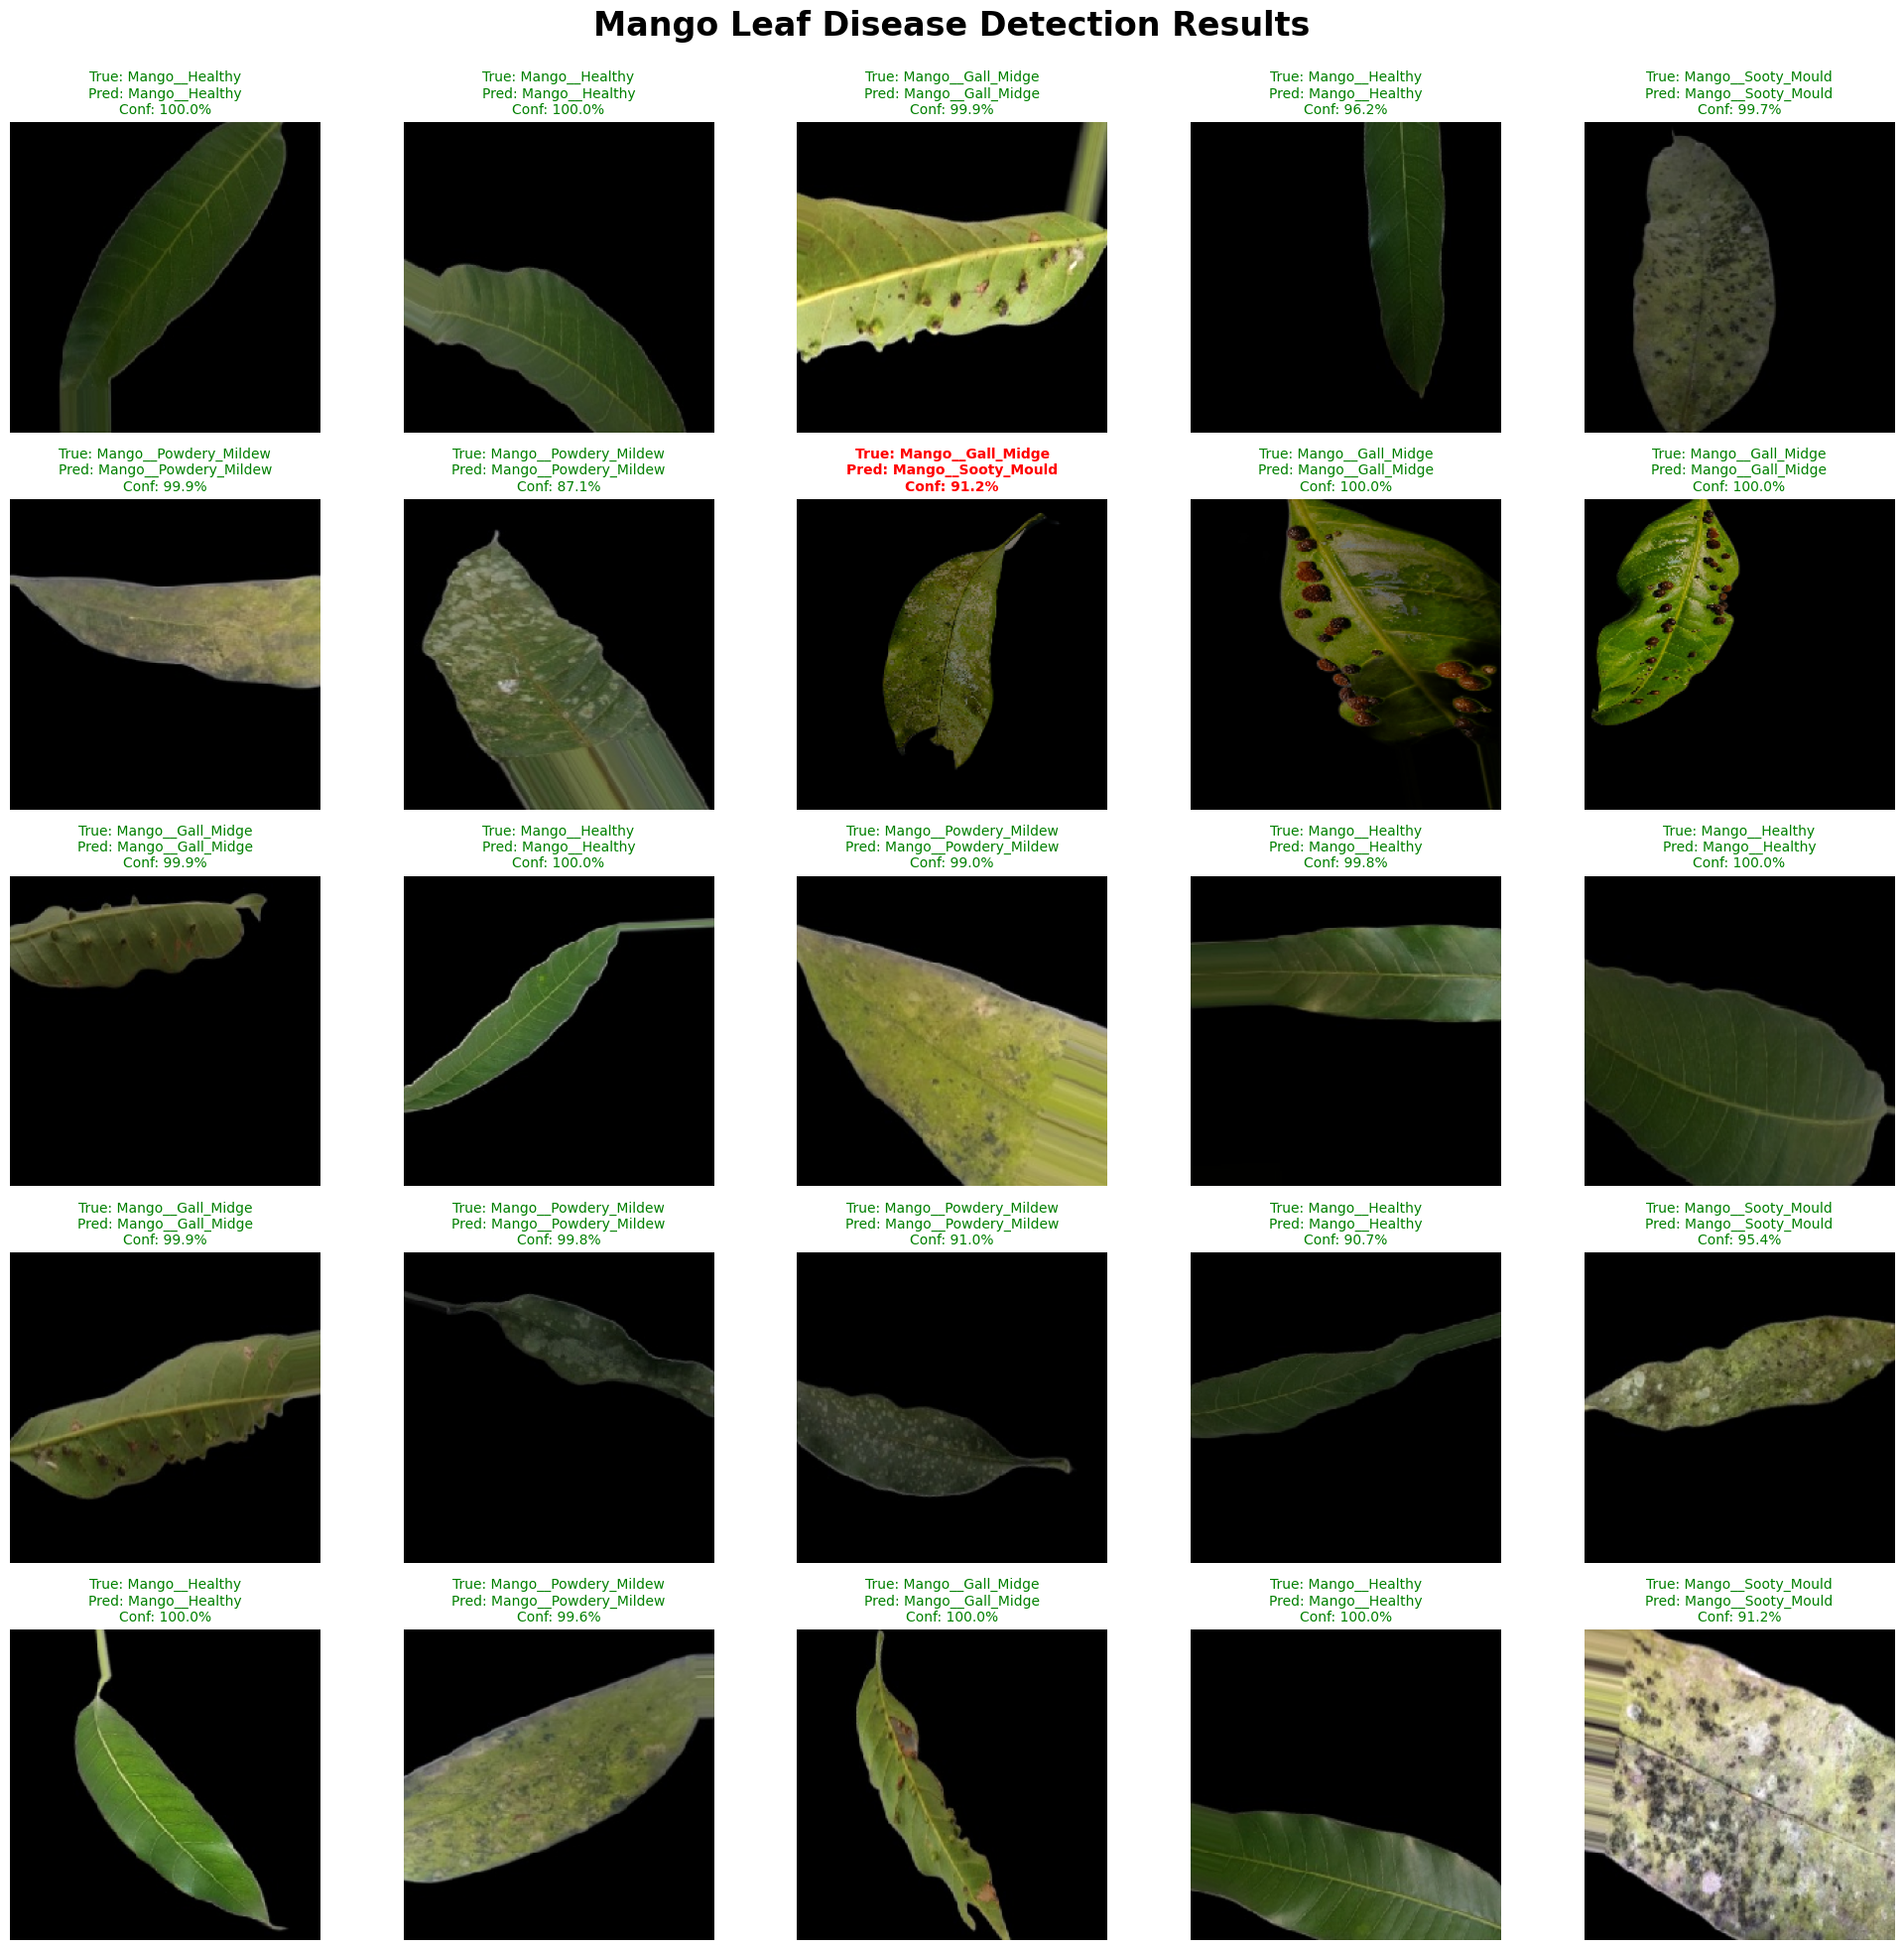

In [28]:
fig1 = create_test_board(model, test_generator, class_names, grid_size=(5, 5))
plt.savefig(f'{PLANT_NAME}_disease_test_board_5x5.png', dpi=300, bbox_inches='tight')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


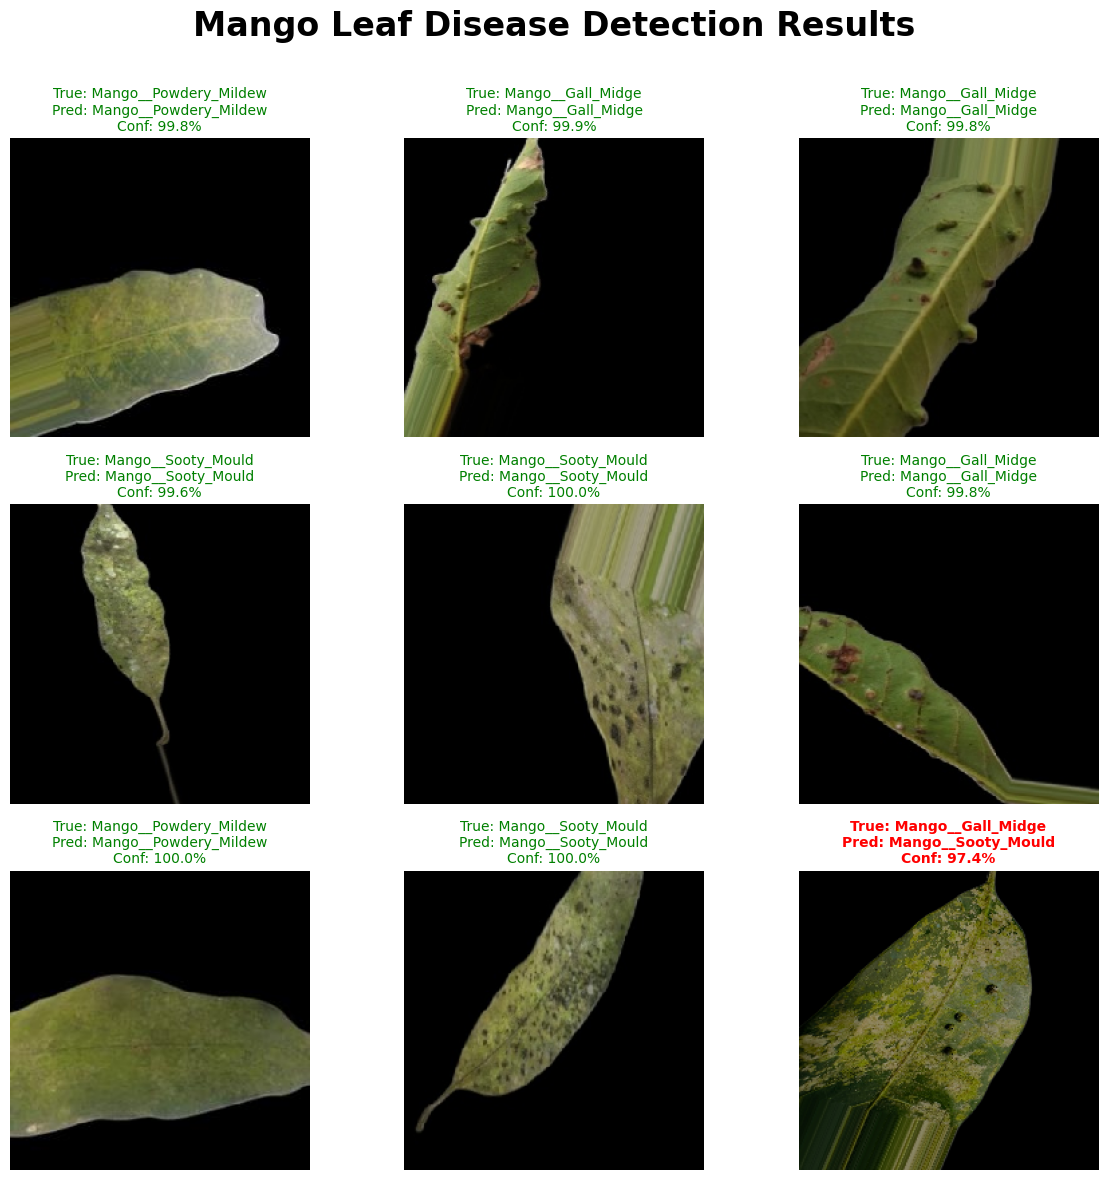

In [29]:
fig2 = create_test_board(model, test_generator, class_names, grid_size=(3, 3), figsize=(12, 12))
plt.savefig(f'{PLANT_NAME}_disease_test_board_3x3.png', dpi=300, bbox_inches='tight')
plt.show()

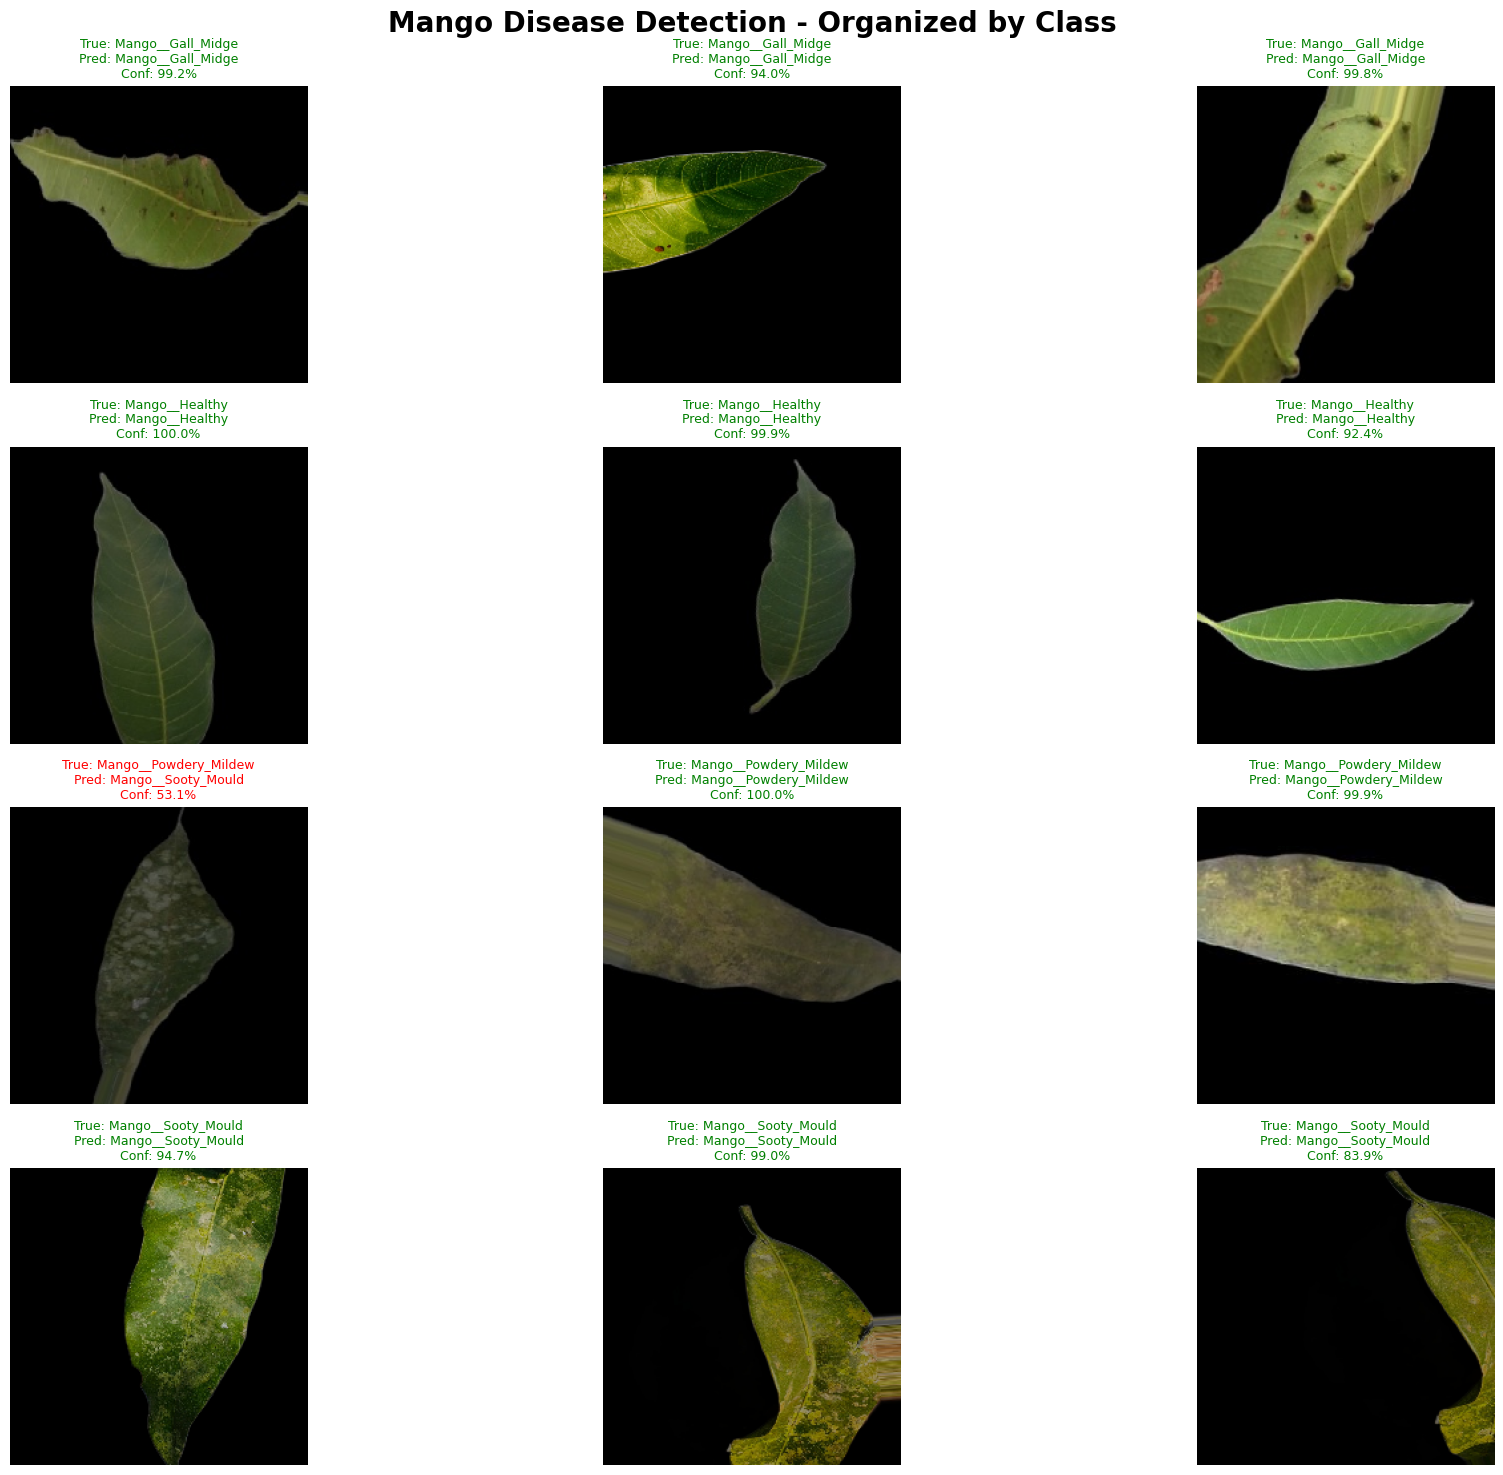

In [30]:
fig3 = create_detailed_test_board(model, test_generator, class_names,
                                     samples_per_class=3)
plt.savefig(f'{PLANT_NAME}_disease_detailed_board.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# !rm -r mango_tester/
# !unzip mango_tester.zip

rm: cannot remove 'mango_tester/': No such file or directory
unzip:  cannot find or open mango_tester.zip, mango_tester.zip.zip or mango_tester.zip.ZIP.


🚀 Initializing Model Tester...
Loading model from /content/Mango_best_model.keras
Model loaded successfully!
Model input shape: (None, 224, 224, 3)
Found classes: ['Mango__Gall_Midge', 'Mango__Healthy', 'Mango__Powdery_Mildew', 'Mango__Sooty_Mould']

🎯 Model will show top 4 predictions per image
🎲 Starting random image testing...

Testing random images from class: Mango__Gall_Midge
Found 4 images in Mango__Gall_Midge
Randomly selected 3 images for testing

--- Image 1/3: 290506darnleyislewalterluimango5-galls-in-upper-leaf-surface.jpg ---
  ✅ Predicted: Mango__Gall_Midge (confidence: 0.9993)
    True class: Mango__Gall_Midge


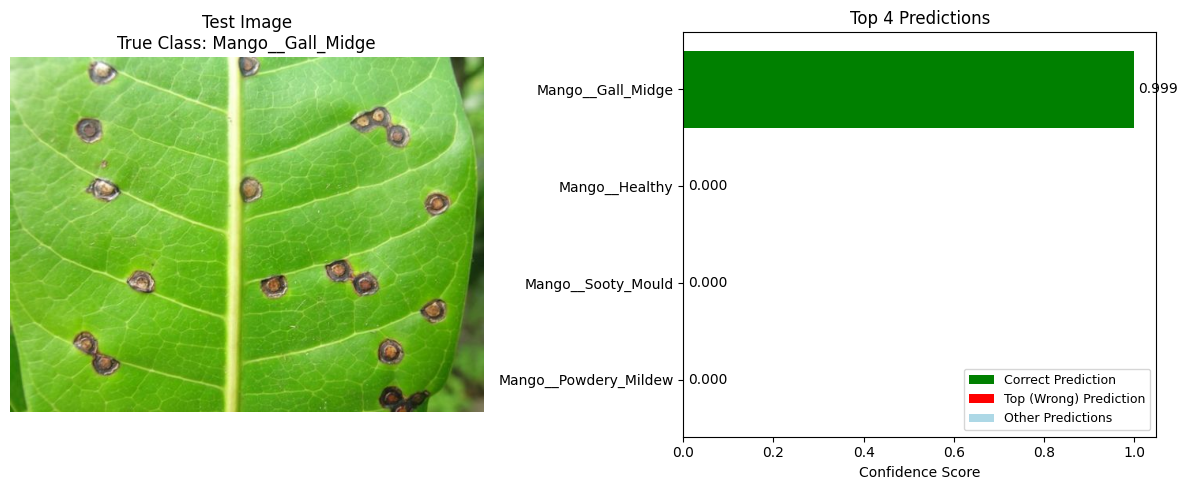

    Detailed predictions:
      1. Mango__Gall_Midge: 0.9993 ✓ (CORRECT)
      2. Mango__Healthy: 0.0004
      3. Mango__Sooty_Mould: 0.0003
      4. Mango__Powdery_Mildew: 0.0000

--- Image 2/3: mango gall midge bb5180c7-d5ff-4efa-a926-107566c01ce2.jpg ---
  ✅ Predicted: Mango__Gall_Midge (confidence: 0.9979)
    True class: Mango__Gall_Midge


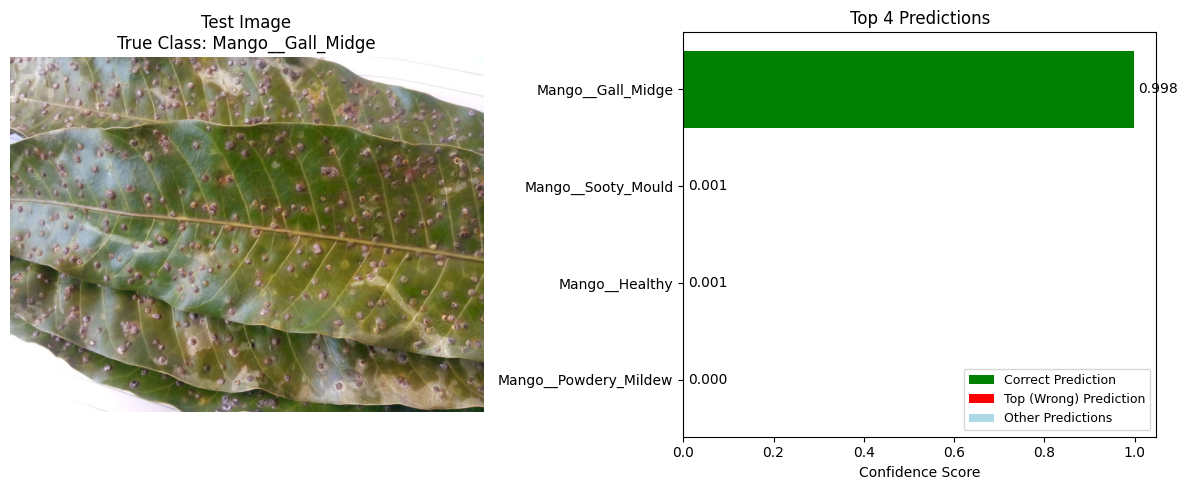

    Detailed predictions:
      1. Mango__Gall_Midge: 0.9979 ✓ (CORRECT)
      2. Mango__Sooty_Mould: 0.0012
      3. Mango__Healthy: 0.0007
      4. Mango__Powdery_Mildew: 0.0002

--- Image 3/3: mango gall midge - charles mwaniki-89649f87-a0fa-46e5-b714-47fd4a60d6fa.jpg ---
  ✅ Predicted: Mango__Gall_Midge (confidence: 0.9834)
    True class: Mango__Gall_Midge


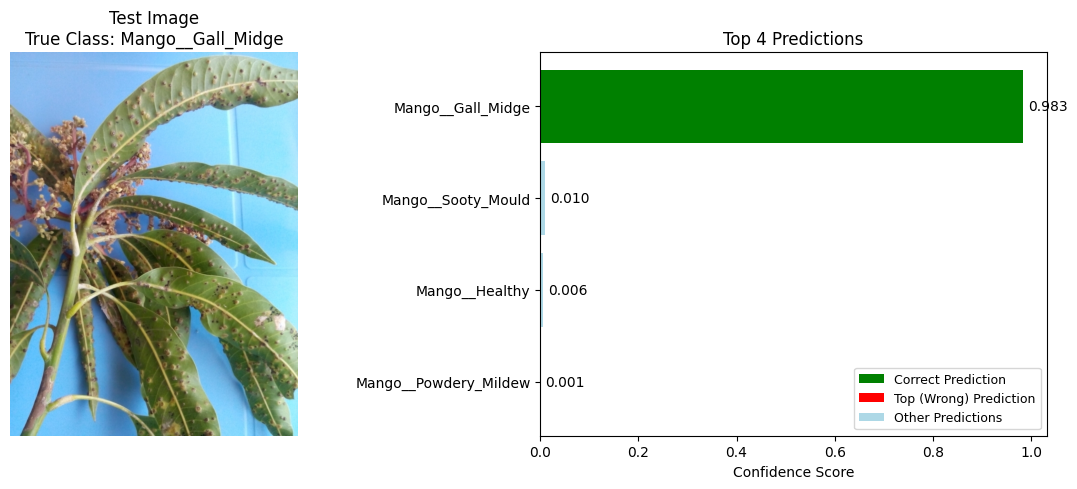

    Detailed predictions:
      1. Mango__Gall_Midge: 0.9834 ✓ (CORRECT)
      2. Mango__Sooty_Mould: 0.0098
      3. Mango__Healthy: 0.0062
      4. Mango__Powdery_Mildew: 0.0006

Testing random images from class: Mango__Healthy
Found 3 images in Mango__Healthy
Randomly selected 3 images for testing

--- Image 1/3: images.jpeg ---
  ✅ Predicted: Mango__Healthy (confidence: 0.6846)
    True class: Mango__Healthy


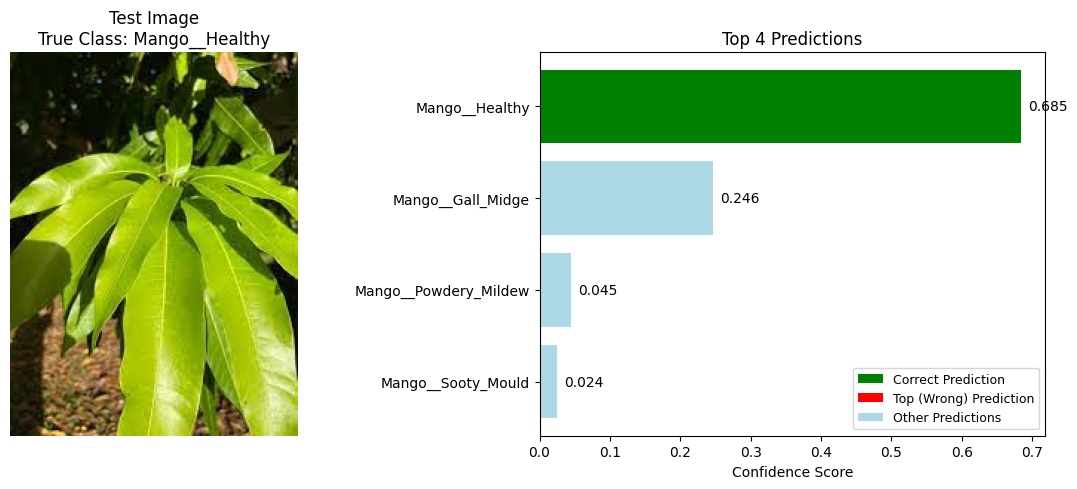

    Detailed predictions:
      1. Mango__Healthy: 0.6846 ✓ (CORRECT)
      2. Mango__Gall_Midge: 0.2463
      3. Mango__Powdery_Mildew: 0.0447
      4. Mango__Sooty_Mould: 0.0244

--- Image 2/3: mango1.jpg ---
  ✅ Predicted: Mango__Healthy (confidence: 0.5164)
    True class: Mango__Healthy


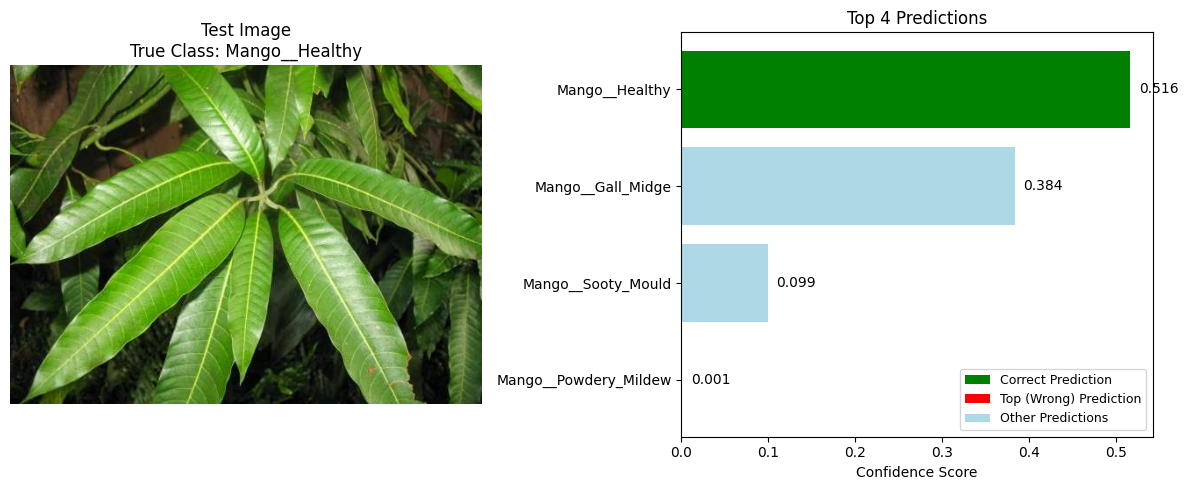

    Detailed predictions:
      1. Mango__Healthy: 0.5164 ✓ (CORRECT)
      2. Mango__Gall_Midge: 0.3836
      3. Mango__Sooty_Mould: 0.0991
      4. Mango__Powdery_Mildew: 0.0008

--- Image 3/3: images (1).jpeg ---
  ❌ Predicted: Mango__Gall_Midge (confidence: 0.5984)
    True class: Mango__Healthy


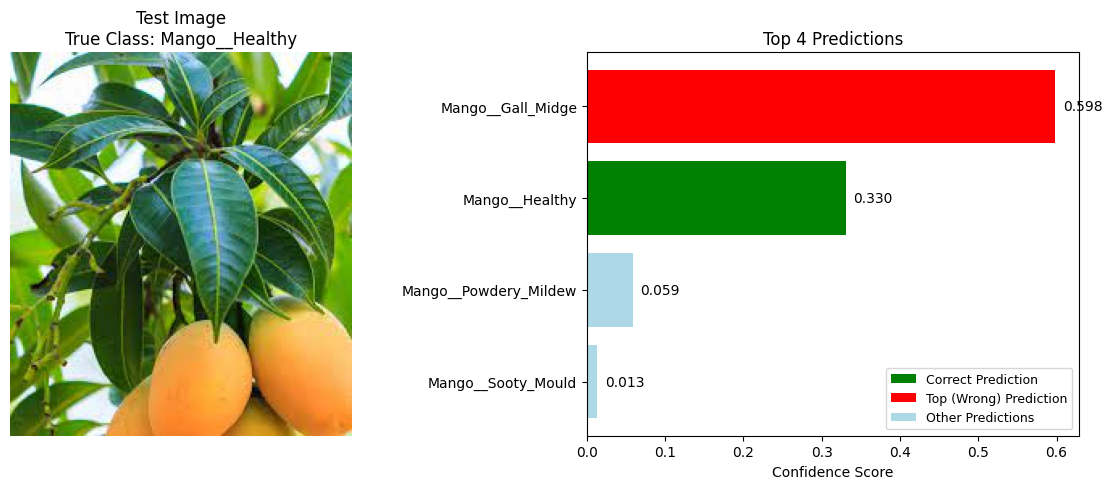

    Detailed predictions:
      1. Mango__Gall_Midge: 0.5984 ✗ (TOP PREDICTION - WRONG)
      2. Mango__Healthy: 0.3304 ✓ (CORRECT)
      3. Mango__Powdery_Mildew: 0.0586
      4. Mango__Sooty_Mould: 0.0126

Testing random images from class: Mango__Powdery_Mildew
Found 1 images in Mango__Powdery_Mildew
Randomly selected 1 images for testing

--- Image 1/1: 20211109_121410 (Custom).jpg ---
  ✅ Predicted: Mango__Powdery_Mildew (confidence: 0.9994)
    True class: Mango__Powdery_Mildew


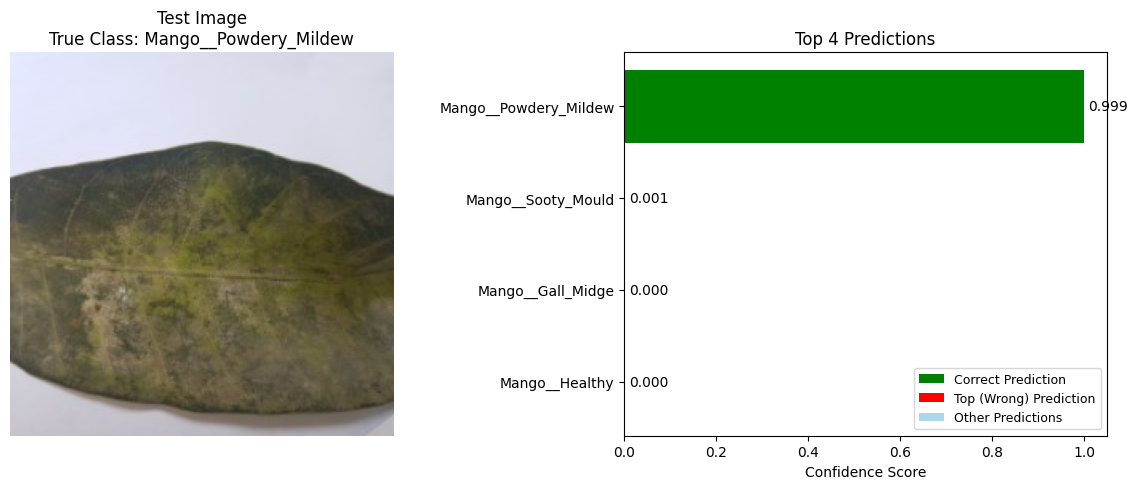

    Detailed predictions:
      1. Mango__Powdery_Mildew: 0.9994 ✓ (CORRECT)
      2. Mango__Sooty_Mould: 0.0006
      3. Mango__Gall_Midge: 0.0000
      4. Mango__Healthy: 0.0000

🔍 COMPREHENSIVE CLASSIFICATION REPORT

📊 OVERALL PERFORMANCE:
   Total images tested: 7
   Correct predictions: 6
   Wrong predictions: 1
   Overall Accuracy: 0.857 (85.7%)

📈 PER-CLASS ACCURACY:
   Mango__Gall_Midge: 3/3 correct = 1.000 (100.0%)
   Mango__Healthy: 2/3 correct = 0.667 (66.7%)
   Mango__Powdery_Mildew: 1/1 correct = 1.000 (100.0%)
   Mango__Sooty_Mould: No images tested

📋 DETAILED SKLEARN CLASSIFICATION REPORT:
--------------------------------------------------
                       precision    recall  f1-score   support

    Mango__Gall_Midge       0.75      1.00      0.86         3
       Mango__Healthy       1.00      0.67      0.80         3
Mango__Powdery_Mildew       1.00      1.00      1.00         1

             accuracy                           0.86         7
            macro a

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

class ModelTester:
    def __init__(self, model_path, test_data_path, class_names=None):
        """
        Initialize the model tester

        Args:
            model_path: Path to .keras model file
            test_data_path: Path to folder containing subfolders with images
            class_names: List of class names (optional, will be inferred from folder names)
        """
        self.model_path = model_path
        self.test_data_path = test_data_path
        self.model = None
        self.class_names = class_names
        self.input_size = (224, 224)

    def load_model(self):
        """Load the trained model"""
        print(f"Loading model from {self.model_path}")
        self.model = tf.keras.models.load_model(self.model_path)
        print("Model loaded successfully!")
        print(f"Model input shape: {self.model.input_shape}")

    def get_class_names(self):
        """Get class names from folder structure"""
        if self.class_names is None:
            self.class_names = sorted([d for d in os.listdir(self.test_data_path)
                                     if os.path.isdir(os.path.join(self.test_data_path, d))])
        print(f"Found classes: {self.class_names}")
        return self.class_names

    def preprocess_image(self, image_path):
        try:
            # Load and resize image
            image = Image.open(image_path).convert('RGB')
            image = image.resize(self.input_size)

            # Convert to array and normalize
            image_array = np.array(image) / 255.0

            # Add batch dimension
            image_array = np.expand_dims(image_array, axis=0)

            return image_array
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None

    def predict_single_image(self, image_path):
        processed_image = self.preprocess_image(image_path)
        if processed_image is None:
            return None, None

        # Get predictions
        predictions = self.model.predict(processed_image, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])

        return predictions[0], predicted_class_idx

    def plot_top_predictions(self, predictions, image_path, true_class=None):
        """
        Plot top N predictions with confidence scores (N = min(5, number of classes))
        Shows TRUE predictions regardless of whether correct class appears or not
        """
        num_classes = len(self.class_names)
        # Show top N predictions, but don't exceed available classes
        top_n = min(5, num_classes)

        # Get top N predictions - this will show the ACTUAL top predictions
        top_indices = np.argsort(predictions)[-top_n:][::-1]
        top_probs = predictions[top_indices]
        top_classes = [self.class_names[i] for i in top_indices]

        # Create the plot
        plt.figure(figsize=(12, 5))

        # Plot the image
        plt.subplot(1, 2, 1)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        title = f"Test Image"
        if true_class:
            title += f"\nTrue Class: {true_class}"
        plt.title(title, fontsize=12)

        # Plot top N predictions
        plt.subplot(1, 2, 2)
        # Color bars: green if prediction matches true class, red if it's the wrong prediction, lightblue for others
        colors = []
        for i, class_name in enumerate(top_classes):
            if true_class and class_name == true_class:
                colors.append('green')  # Correct prediction
            elif i == 0:  # Top prediction but wrong
                colors.append('red')
            else:
                colors.append('lightblue')  # Other predictions

        bars = plt.barh(range(len(top_probs)), top_probs, color=colors)
        plt.yticks(range(len(top_probs)), top_classes)
        plt.xlabel('Confidence Score')
        plt.title(f'Top {top_n} Predictions')
        plt.gca().invert_yaxis()

        # Add confidence values on bars
        for i, (bar, prob) in enumerate(zip(bars, top_probs)):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{prob:.3f}', va='center', fontsize=10)

        # Add legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, facecolor='green', label='Correct Prediction'),
            plt.Rectangle((0,0),1,1, facecolor='red', label='Top (Wrong) Prediction'),
            plt.Rectangle((0,0),1,1, facecolor='lightblue', label='Other Predictions')
        ]
        plt.legend(handles=legend_elements, loc='lower right', fontsize=9)

        plt.tight_layout()
        plt.show()

        # Print detailed prediction info
        print(f"    Detailed predictions:")
        for i, (class_name, prob) in enumerate(zip(top_classes, top_probs)):
            status = ""
            if true_class:
                if class_name == true_class:
                    status = " ✓ (CORRECT)"
                elif i == 0:
                    status = " ✗ (TOP PREDICTION - WRONG)"
            print(f"      {i+1}. {class_name}: {prob:.4f}{status}")

    def test_random_images(self, images_per_class=3):
        """Test random images from each class"""
        results = []
        # np.random.seed(42)  # For reproducible results, remove if you want different random selection each time

        for class_name in self.class_names:
            class_path = os.path.join(self.test_data_path, class_name)
            if not os.path.exists(class_path):
                print(f"Warning: Class folder '{class_name}' not found!")
                continue

            print(f"\n{'='*60}")
            print(f"Testing random images from class: {class_name}")
            print(f"{'='*60}")

            # Get all image files
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            if not image_files:
                print(f"  No images found in {class_name}")
                continue

            print(f"Found {len(image_files)} images in {class_name}")

            # Randomly select images
            num_to_select = min(images_per_class, len(image_files))
            selected_images = np.random.choice(image_files, num_to_select, replace=False)
            print(f"Randomly selected {num_to_select} images for testing")

            for idx, image_file in enumerate(selected_images):
                print(f"\n--- Image {idx+1}/{num_to_select}: {image_file} ---")

                image_path = os.path.join(class_path, image_file)
                predictions, predicted_idx = self.predict_single_image(image_path)

                if predictions is not None:
                    predicted_class = self.class_names[predicted_idx]
                    confidence = predictions[predicted_idx]
                    is_correct = class_name == predicted_class

                    results.append({
                        'image_path': image_path,
                        'image_file': image_file,
                        'true_class': class_name,
                        'predicted_class': predicted_class,
                        'confidence': confidence,
                        'correct': is_correct
                    })

                    status_emoji = "✅" if is_correct else "❌"
                    print(f"  {status_emoji} Predicted: {predicted_class} (confidence: {confidence:.4f})")
                    print(f"    True class: {class_name}")

                    # Show top predictions for this image
                    self.plot_top_predictions(predictions, image_path, true_class=class_name)
                else:
                    print(f"  ❌ Failed to process image: {image_file}")

        return pd.DataFrame(results)

    def plot_confusion_matrix(self, results_df):
        """Plot confusion matrix"""
        if results_df.empty:
            print("No results to plot confusion matrix")
            return

        y_true = results_df['true_class']
        y_pred = results_df['predicted_class']

        cm = confusion_matrix(y_true, y_pred, labels=self.class_names)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix - Model Performance')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def generate_report(self, results_df):
        """Generate comprehensive classification report"""
        if results_df.empty:
            print("No results to generate report")
            return

        print("\n" + "="*70)
        print("🔍 COMPREHENSIVE CLASSIFICATION REPORT")
        print("="*70)

        # Overall accuracy
        total_images = len(results_df)
        correct_predictions = results_df['correct'].sum()
        accuracy = results_df['correct'].mean()

        print(f"\n📊 OVERALL PERFORMANCE:")
        print(f"   Total images tested: {total_images}")
        print(f"   Correct predictions: {correct_predictions}")
        print(f"   Wrong predictions: {total_images - correct_predictions}")
        print(f"   Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

        # Per-class accuracy
        print(f"\n📈 PER-CLASS ACCURACY:")
        class_stats = results_df.groupby('true_class').agg({
            'correct': ['count', 'sum', 'mean']
        }).round(3)

        for class_name in self.class_names:
            if class_name in class_stats.index:
                total = class_stats.loc[class_name, ('correct', 'count')]
                correct = class_stats.loc[class_name, ('correct', 'sum')]
                accuracy = class_stats.loc[class_name, ('correct', 'mean')]
                print(f"   {class_name}: {correct}/{total} correct = {accuracy:.3f} ({accuracy*100:.1f}%)")
            else:
                print(f"   {class_name}: No images tested")

        # Detailed classification report
        print(f"\n📋 DETAILED SKLEARN CLASSIFICATION REPORT:")
        print("-" * 50)
        print(classification_report(results_df['true_class'], results_df['predicted_class']))

        # Show some example wrong predictions
        wrong_predictions = results_df[~results_df['correct']]
        if not wrong_predictions.empty:
            print(f"\n❌ EXAMPLE WRONG PREDICTIONS:")
            print("-" * 50)
            for _, row in wrong_predictions.head(5).iterrows():
                print(f"   Image: {row['image_file']}")
                print(f"   True: {row['true_class']} → Predicted: {row['predicted_class']} (conf: {row['confidence']:.3f})")
                print()

def main():
    """Main function to run the model testing"""
    # Configure these paths according to your setup
    MODEL_PATH = "/content/drive/MyDrive/Mango_best_model.keras"  # Path to your trained model
    TEST_DATA_PATH = "/content/mango_tester"   # Path to folder containing disease folders

    # Optional: Define class names explicitly (will be auto-detected if None)
    CLASS_NAMES = class_names

    try:
        # Initialize tester
        print("🚀 Initializing Model Tester...")
        tester = ModelTester(MODEL_PATH, TEST_DATA_PATH, class_names=CLASS_NAMES)

        # Load model and get class names
        tester.load_model()
        tester.get_class_names()

        print(f"\n🎯 Model will show top {min(5, len(tester.class_names))} predictions per image")
        print("🎲 Starting random image testing...")

        # Test random images (you can change images_per_class)
        results_df = tester.test_random_images(images_per_class=3)

        # Generate comprehensive report
        if not results_df.empty:
            tester.generate_report(results_df)

            # # Plot confusion matrix
            # print("\n📈 Generating confusion matrix...")
            # tester.plot_confusion_matrix(results_df)

            # Save results
            output_file = "random_test_results.csv"
            results_df.to_csv(output_file, index=False)
            print(f"\n💾 Results saved to {output_file}")

            print("\n✅ Testing completed successfully!")
        else:
            print("\n❌ No images were processed successfully. Please check your paths and image files.")

    except Exception as e:
        print(f"\n❌ Error occurred: {str(e)}")
        print("Please check your model path, test data path, and ensure all dependencies are installed.")

main()